In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(palette=sns.color_palette('magma'))

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import ConfusionMatrix, AUROC

from transformers import RobertaTokenizer, RobertaForSequenceClassification

### Load preprocessed data

In [4]:
train_data = pd.read_csv('data/train.csv.gz')
val_data = pd.read_csv('data/val.csv.gz')
test_data = pd.read_csv('data/test.csv.gz')

In [5]:
train_data.head()

,text,topic
0,Тренер филиппинского боксера Мэнни Пакиао Фред...,Спорт
1,Российский боксер Денис Лебедев рассказал поед...,Спорт
2,"На найти качественные товары детей , функциона...",Семья
3,"Международная группа физиков России , Великобр...",Космос
4,"Лето самом разгаре , асфальт плавится жары , м...",Здоровье


In [6]:
TOPICS = train_data.topic.unique()
N_TOPICS = len(TOPICS)

TOPIC2ID = {topic: i for i, topic in enumerate(TOPICS)}
TOPIC2ID

{'Спорт': 0,
 'Семья': 1,
 'Космос': 2,
 'Здоровье': 3,
 'Кино и телевидение': 4,
 'Компьютерные игры': 5,
 'Красота и мода': 6,
 'Политика': 7,
 'Экономика': 8,
 'Животные': 9,
 'Преступления': 10,
 'Дома и недвижимость': 11,
 'Социальная сфера': 12,
 'Наука и технологии': 13,
 'Еда и рецепты': 14,
 'Культура и искусство': 15,
 'Автомобили': 16}

In [7]:
len(train_data), len(val_data), len(test_data)

(17426, 5809, 7746)

### Load pretrained tokenizer and model (RuRoberta)

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [9]:
CHECKPOINT = 'ai-forever/ruRoberta-large'
MAX_LENGTH = 512

tokenizer = RobertaTokenizer.from_pretrained(CHECKPOINT)
model = RobertaForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=N_TOPICS).to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Implement dataset class

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, data: pd.DataFrame) -> None:
        self.X = tokenizer(data.text.to_list(), padding=True, truncation=True, max_length=MAX_LENGTH,
                           add_special_tokens=True, return_tensors='pt')
        self.y = data.topic.to_list()

    def __getitem__(self, index: int) -> dict:
        return {'input_ids': self.X['input_ids'][index],
                'attention_mask': self.X['attention_mask'][index],
                'labels': TOPIC2ID[self.y[index]]}

    def __len__(self) -> int:
        return len(self.y)

### Create train dataset and dataloader

In [11]:
train_dataset = SequenceDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)

### Fine-tune model

In [12]:
N_EPOCHS = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.train()

for epoch in range(N_EPOCHS):
    for i, batch in enumerate(train_dataloader):
        batch = {key: value.to(DEVICE) for key, value in batch.items()}

        optimizer.zero_grad()
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(loss)

tensor(2.7439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6703, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3746, device='cuda:0', grad_fn=

### Save model

In [13]:
model.save_pretrained('models/roberta-for-topic-prediction', from_pt=True)

### Compute metrics on test data

In [14]:
from torcheval.metrics.functional import multiclass_f1_score
from torchmetrics import ROC
from torchmetrics.classification import MulticlassROC

In [16]:
test_dataset = SequenceDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=6)

In [18]:
model.eval()

targets = []
predictions = []
probabilities = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {key: value.to(DEVICE) for key, value in batch.items()}

        outputs = model(**batch)

        targets.append(batch['labels'])
        p = torch.softmax(outputs.logits, dim=1)
        
        predictions.append(p.argmax(dim=1))
        probabilities.append(p)

In [19]:
predictions_merged = torch.hstack(predictions)
targets_merged = torch.hstack(targets)
probabilities_merged = torch.vstack(probabilities)

### Confusion matrix

In [20]:
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=N_TOPICS, normalize='true').to(DEVICE)

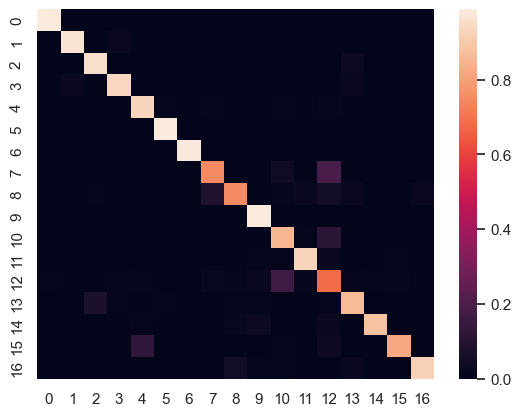

In [22]:
sns.heatmap(confusion_matrix(predictions_merged, targets_merged).detach().cpu())
plt.savefig('plots/confusion_matrix.png', dpi=400, bbox_inches='tight')

### F1-score

In [23]:
multiclass_f1_score(predictions_merged, targets_merged, num_classes=N_TOPICS)

tensor(0.8916, device='cuda:0')

### AUC ROC

In [24]:
from torchmetrics import AUROC

In [25]:
auroc = AUROC(task='multiclass', num_classes=N_TOPICS)
print('AUC ROC:', auroc(probabilities_merged, targets_merged), sep='\t')

AUC ROC:	tensor(0.9934, device='cuda:0')


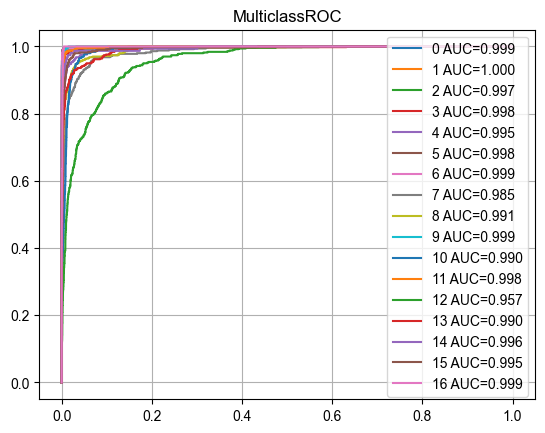

In [30]:
multiclass_roc = MulticlassROC(num_classes=N_TOPICS)
multiclass_roc.update(probabilities_merged, targets_merged)
multiclass_roc.plot(score=True)

plt.savefig('plots/roc_curve.png', dpi=400, bbox_inches='tight')